# Reddit Statistics Visualizations

## Imports and PRAW Login

* PRAW: Used to request Reddit data via Reddit API
* Pandas: Used to handle data via dataframes
* Datetime: Used to handle datetime objects
* Seaborn: Used to create visualizations
* Matplotlib: Used to create visualizations
* Config: Contains confidential information

In [2]:
import praw
from praw.models import MoreComments
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import config

In [3]:
sns.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=26)     # fontsize of the axes title
plt.rc('axes', labelsize=17)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)          # controls default text sizes

In [4]:
#shows contains show names and iMDB links of shows up for consideration by Bantr
shows = pd.read_csv('raw/shows.csv')
shows.columns = ['Show', 'Link']
show_list = shows['Show'].tolist()
show_list = list(map(lambda x: x.lower(), show_list))

#reddits contains show names, primary subreddits, and iMDB link of several shows
reddits = pd.read_csv('raw/reddit_shows.csv')
reddits.columns = ['Show', 'Sub']
reddits['Normal_Sub'] = reddits['Sub'].str.replace("r/",'').str.lower()

#on_app contains show names and iMDB links for shows currently on Bantr
on_app = pd.read_csv('raw/current_on_app.csv')

In [5]:
reddit = praw.Reddit(
    client_id=config.client_id,
    client_secret=config.client_secret,
    password=config.password,
    user_agent=config.user_agent,
    username=config.username,
)

Version 7.7.0 of praw is outdated. Version 7.7.1 was released Tuesday July 11, 2023.


In [6]:
#gets current subscriber numbers from a subreddit
def getSubscribers(row):
    try:
        subreddit = reddit.subreddit(row['Normal_Sub'])
        return subreddit.subscribers
    except:
        return 0

In [7]:
#gets current active users from a subreddit
def getActive(row):
    try:
        subreddit = reddit.subreddit(row['Normal_Sub'])
        return subreddit.active_user_count
    except:
        return 0

In [9]:
#initialize subscriber column in reddits
reddits['Subscribers'] = reddits.apply(lambda row: getSubscribers(row), axis=1)    

In [10]:
#initialize Active Users column in reddits and normalize by 1000
reddits['Active Users'] = reddits.apply(lambda row: getActive(row), axis = 1)
reddits['Active Users'] = round(reddits['Active Users']/1000, 2)

In [11]:
#create active_df to display most active subreddits
active_df = reddits.sort_values(by=['Active Users'], ascending=False)

## Visualizations

A bar chart that displays current active users over several show subreddits was created to display the current most active show discussions and highlight which are currently on the app and which are not.

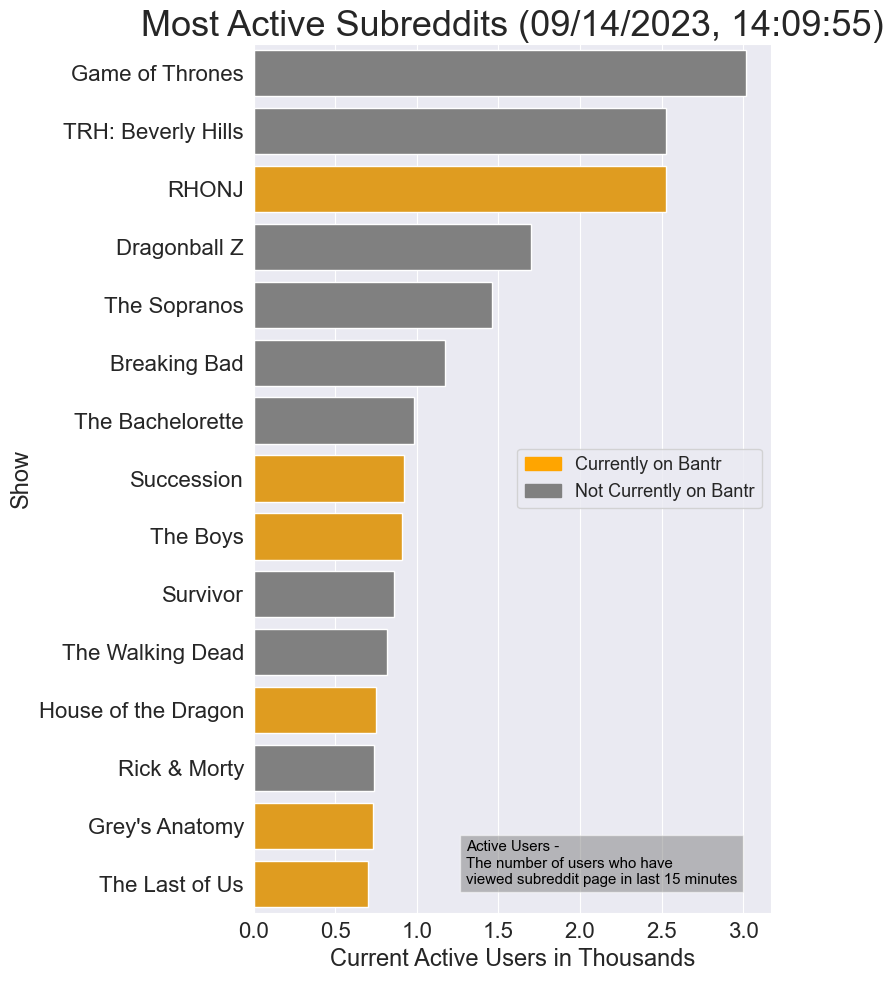

In [19]:
sns.set_palette('pastel')
currentDateAndTime = datetime.now()
currentTime = currentDateAndTime.strftime("%m/%d/%Y, %H:%M:%S")
font = {'family': 'arial',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
cols = ['orange' if x in on_app['Show'].tolist() else 'grey' for x in active_df['Show']]
plt.figure(figsize=(8,10), tight_layout=True)
ax = sns.barplot(x=active_df['Active Users'].head(15), y=active_df['Show'].head(15), palette=cols, errorbar=None)
ax.set(title=f'Most Active Subreddits ({currentTime})', xlabel='Current Active Users in Thousands', ylabel='Show')
plt.text(1.3, 14, "Active Users -\nThe number of users who have\nviewed subreddit page in last 15 minutes", horizontalalignment='left', size='small', fontdict=font,bbox=dict(facecolor='grey', alpha=0.5))
orange_patch = mpatches.Patch(color='orange', label='Currently on Bantr')
grey_patch = mpatches.Patch(color='grey', label='Not Currently on Bantr')
ax.legend(handles=[orange_patch, grey_patch], loc='center right')
plt.show()

A bar chart that displays total subscribers on several show subreddits was created to indicate the size of historical fanbases along with which are currently on the app and which are not.

In [20]:
subs_df = reddits.sort_values(by=['Subscribers'], ascending=False)
subs_df = subs_df.head(15)
subs_df['Subscribers'] = round(subs_df['Subscribers']/1000000, 2)

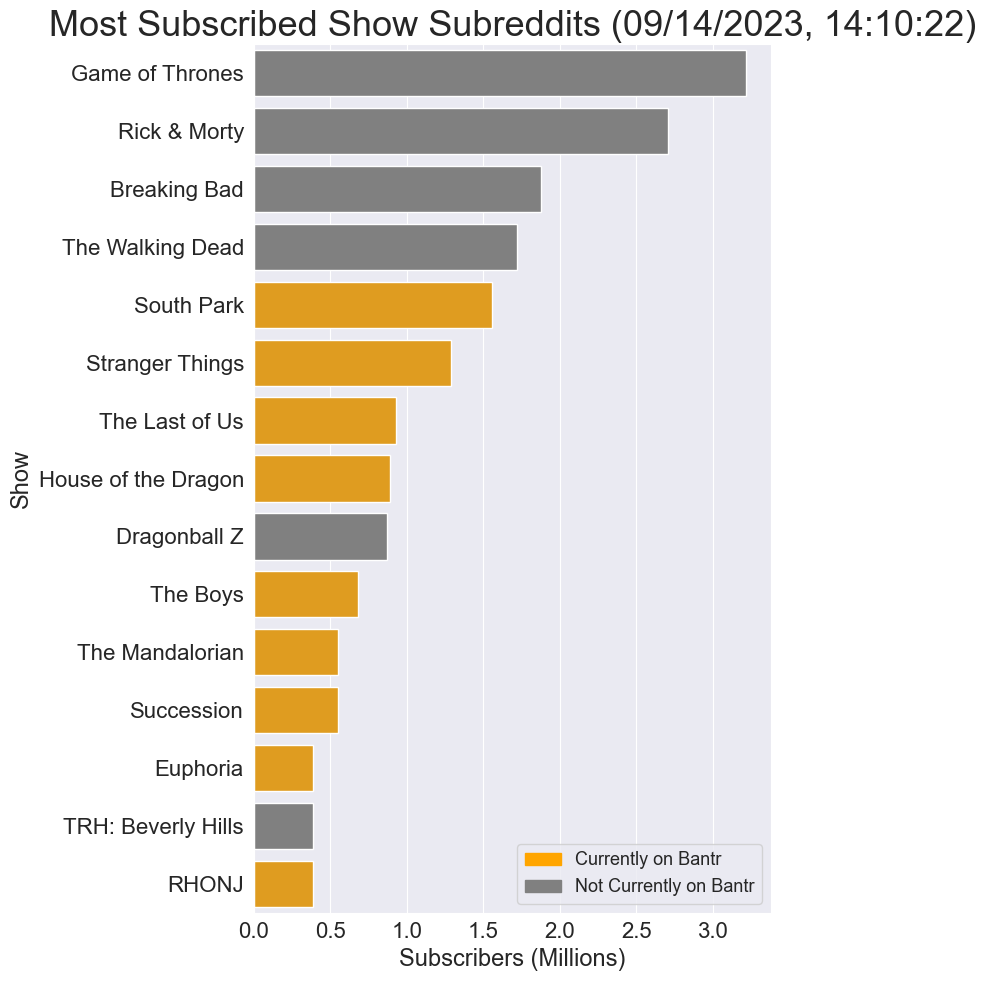

In [21]:
currentDateAndTime = datetime.now()
currentTime = currentDateAndTime.strftime("%m/%d/%Y, %H:%M:%S")
plt.figure(figsize=(8,10), tight_layout=True)
cols = ['orange' if x in on_app['Show'].tolist() else 'grey' for x in subs_df['Show']]
ax = sns.barplot(x=subs_df['Subscribers'], y=subs_df['Show'], palette=cols, errorbar=None)
ax.set(title=f'Most Subscribed Show Subreddits ({currentTime})', xlabel='Subscribers (Millions)', ylabel='Show')
orange_patch = mpatches.Patch(color='orange', label='Currently on Bantr')
grey_patch = mpatches.Patch(color='grey', label='Not Currently on Bantr')
ax.legend(handles=[orange_patch, grey_patch])
plt.show()

In [24]:
#Initialize comments data
comments = pd.read_csv('raw/comments_past_year.csv')
comments = comments[:-1]
comments['Date'] = comments['Unnamed: 0'].str.replace("20:00", '')
del comments['Unnamed: 0']
comments['Date'] = pd.to_datetime(comments['Date'])
first_com = comments.pop('Date')
comments = comments.interpolate()
comments = comments.fillna(0)
comments.insert(0,'Date', first_com)

**_Note_:** Comment data was collected from [Subreddit Stats](https://subredditstats.com/)

In [28]:
total_comments = pd.read_csv('raw/total_comments.csv')
total_comments = total_comments.rename(columns={'Total': 'Total Comments', 'Unnamed: 0': 
    'Show'})

In [29]:
comments_df = total_comments.sort_values(by=['Total Comments'], ascending=False)
comments_df = comments_df.head(15)
comments_df['Total Comments'] = comments_df['Total Comments']/100000

Bar chart is created to display the most active subreddits for shows currently on the app over the past calendar year.

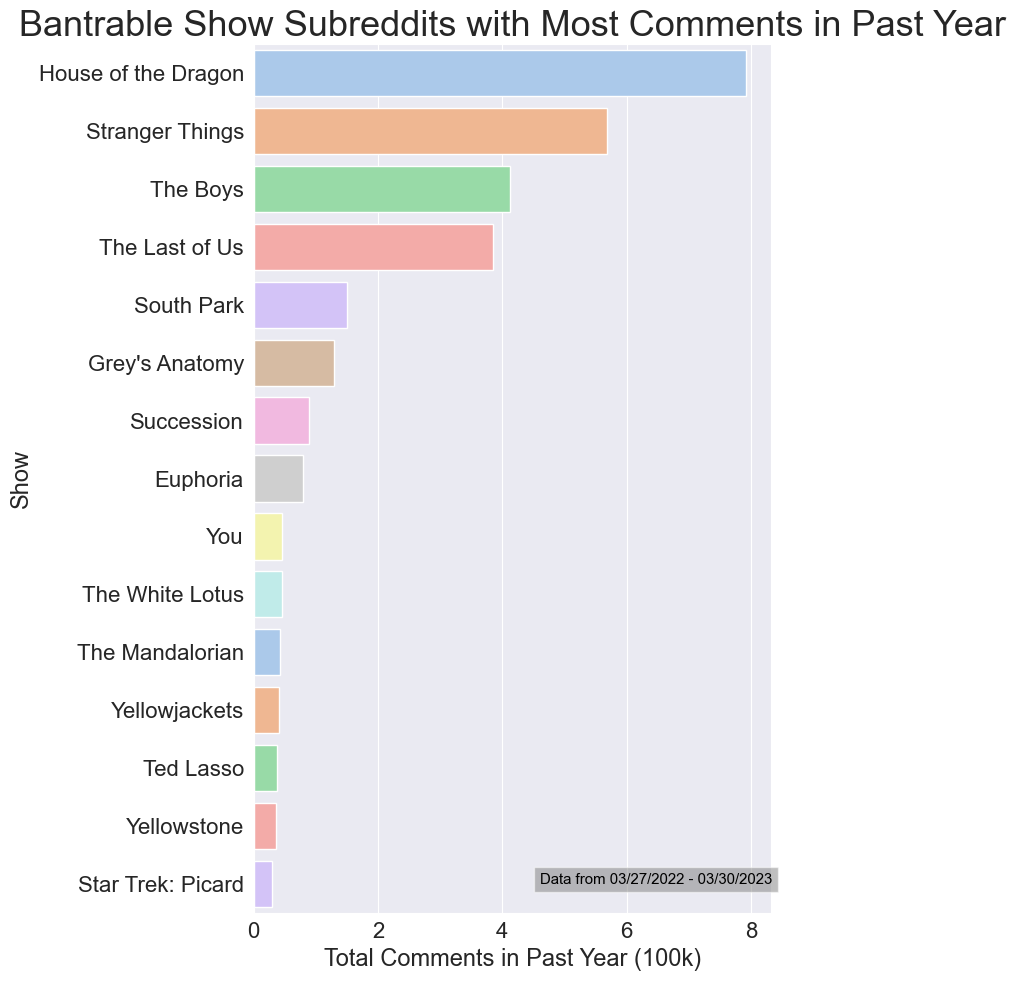

In [30]:
plt.figure(figsize=(8,10), tight_layout=True)
ax = sns.barplot(x=comments_df['Total Comments'], y=comments_df['Show'], palette='pastel', errorbar=None)
ax.set(title='Bantrable Show Subreddits with Most Comments in Past Year', xlabel='Total Comments in Past Year (100k)', ylabel='Show')
font = {'family': 'arial',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }
plt.text(4.6, 14, "Data from 03/27/2022 - 03/30/2023", horizontalalignment='left', size='small', fontdict=font,bbox=dict(facecolor='grey', alpha=0.5))
plt.show()

## Show Fingerprint Analysis

Created various line charts to display the activity patterns of Reddit users in a show's subreddit during its release.

Four shows that each use different release schedules were used.

In [34]:
top_comments = pd.DataFrame()
top_comments['Stranger Things'] = comments['Stranger Things']
top_comments['The Boys'] = comments['The Boys']
top_comments['The Last of Us'] = comments['The Last of Us']
top_comments['Wednesday'] = comments['Wednesday']
top_comments['Date'] = comments['Date']

In [35]:
dates_raw = pd.read_csv('raw/release_dates.csv')
for reddit in dates_raw.columns.values:
    dates_raw[f'{reddit}'] = pd.to_datetime(dates_raw[f'{reddit}'], errors='coerce')
dates_raw.fillna(-1, inplace=True)
dates_raw.head()

,The Boys,Wendesday,The Last of Us,Stranger Things,Yellowjackets,Survivor,Ted Lasso S1,Ted Lasso S2,The Handmaids Tale,The Bachelorette
0,2022-06-03 00:00:00,2022-11-23 00:00:00,2023-01-15 00:00:00,2022-05-20 00:00:00,2021-11-14 00:00:00,2022-09-21,2020-08-14 00:00:00,2021-07-23 00:00:00,2022-09-14 00:00:00,2021-06-07 00:00:00
1,2022-06-10 00:00:00,-1,2023-01-22 00:00:00,2022-07-01 00:00:00,2021-11-21 00:00:00,2022-09-28,2020-08-21 00:00:00,2021-07-30 00:00:00,-1,2021-06-14 00:00:00
2,2022-06-17 00:00:00,-1,2023-01-29 00:00:00,-1,2021-11-28 00:00:00,2022-10-05,2020-08-28 00:00:00,2021-08-06 00:00:00,2022-09-21 00:00:00,2021-06-21 00:00:00
3,2022-06-24 00:00:00,-1,2023-02-05 00:00:00,-1,2021-12-05 00:00:00,2022-10-12,2020-09-04 00:00:00,2021-08-13 00:00:00,2022-09-28 00:00:00,2021-06-28 00:00:00
4,2022-07-01 00:00:00,-1,2023-02-10 00:00:00,-1,2021-12-12 00:00:00,2022-10-19,2020-09-11 00:00:00,2021-08-20 00:00:00,2022-10-05 00:00:00,2021-07-05 00:00:00


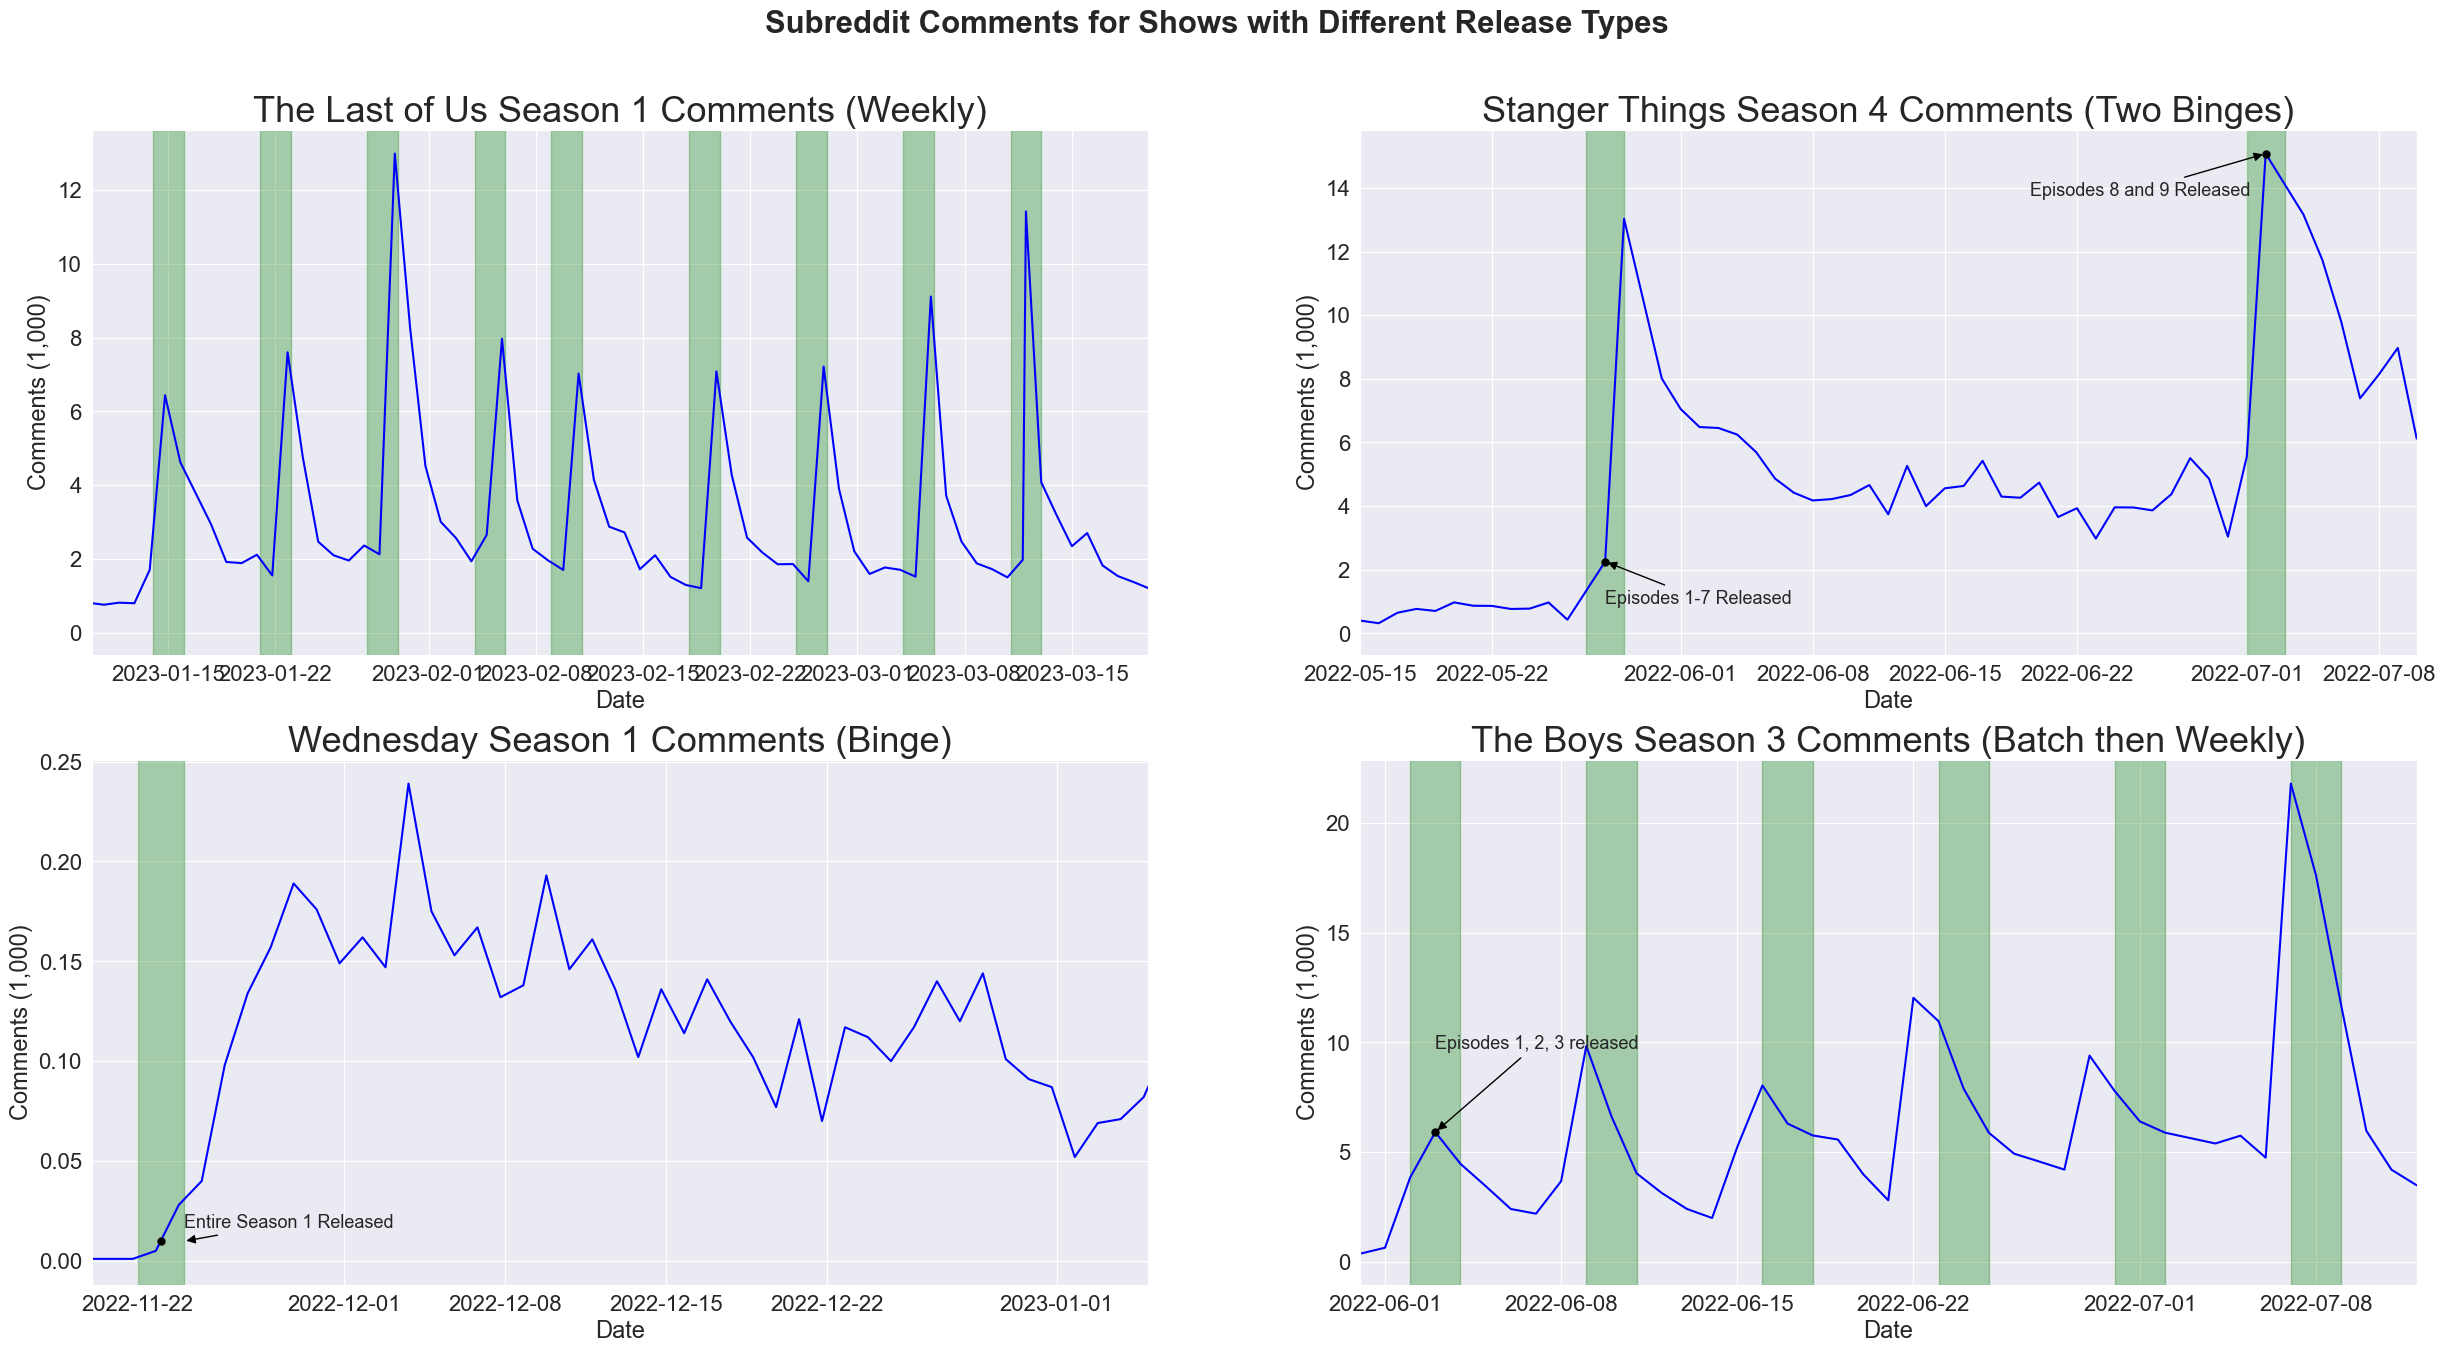

In [36]:
import calendar
import matplotlib.dates as mdates
fig, ax = plt.subplots(2,2,sharex=False, sharey=False, figsize=(30,15))
fig.suptitle('Subreddit Comments for Shows with Different Release Types', size='xx-large', y = 0.96, weight='bold')
sns.lineplot(ax=ax[1,1], x = top_comments['Date'], y = top_comments['The Boys']/1000, color='b')
ax[1,1].set_xlim([dt.date(2022, 5, 31), dt.date(2022, 7, 12)])
releasedates = dates_raw.loc[:,'The Boys']
for episode, x in enumerate(releasedates):
  if x != -1:
    year = x.year
    month = x.month
    day = x.day
    if(day == 1):
      ax[1,1].axvspan(dt.date(year, month - 1, calendar.monthrange(year, month - 1)[1]),
                 dt.date(year, month, day + 1), color="green", alpha=0.3)
    elif (day == calendar.monthrange(year, month)[1]):
      ax[1,1].axvspan(dt.date(year, month, day - 1), 
               dt.date(year, month + 1, 1), color="green", alpha=0.3)
    else:
      ax[1,1].axvspan(dt.date(year, month, day - 1), 
               dt.date(year, month, day + 1), color="green", alpha=0.3)
ax[1,1].set(title='The Boys Season 3 Comments (Batch then Weekly)',ylabel="Comments (1,000)",xlabel='Date')
y = top_comments.loc[top_comments['Date'] == dt.datetime(2022, 6, 3), 'The Boys'].item()/1000
ax[1,1].plot(dt.date(2022, 6, 3), y, marker = "o", markersize = 5, 
        markeredgecolor = "black", markerfacecolor = "black")
ax[1,1].annotate('Episodes 1, 2, 3 released', (dt.date(2022, 6, 3), y), xytext = (0,60),
                 textcoords='offset points', arrowprops=dict(arrowstyle='-|>', color='black'))


sns.lineplot(ax=ax[1,0], x = top_comments['Date'], y = top_comments['Wednesday']/1000, color='b')
ax[1,0].set_xlim([dt.date(2022, 11, 20), dt.date(2023, 1, 5)])
ax[1,0].set(title='Wednesday Season 1 Comments (Binge)',ylabel="Comments (1,000)",xlabel='Date')
ax[1,0].axvspan(dt.date(2022,11,22), dt.date(2022,11,24), color = "green", alpha=0.3)
y = 0.0098
ax[1,0].plot(dt.date(2022,11,23), y, marker = 'o', markersize = 5,
             markeredgecolor = 'black', markerfacecolor = 'black')
ax[1,0].annotate('Entire Season 1 Released', (dt.date(2022, 11, 24), y), xytext = (0,10),
                 textcoords='offset points', arrowprops=dict(arrowstyle='-|>', color='black'))


sns.lineplot(ax=ax[0,1], x = top_comments['Date'], y = top_comments['Stranger Things']/1000, color='b')
ax[0,1].set_xlim([dt.date(2022, 5, 15), dt.date(2022, 7, 10)])
ax[0,1].set(title='Stanger Things Season 4 Comments (Two Binges)',ylabel="Comments (1,000)",xlabel='Date')
ax[0,1].axvspan(dt.date(2022,5,27), dt.date(2022,5,29), color = "green", alpha=0.3)
y = top_comments.loc[top_comments['Date'] == dt.datetime(2022, 5, 28), 'Stranger Things'].item()/1000
ax[0,1].plot(dt.date(2022,5,28), y, marker = 'o', markersize = 5,
             markeredgecolor = 'black', markerfacecolor = 'black')
ax[0,1].annotate('Episodes 1-7 Released', (dt.date(2022, 5, 28), y), xytext = (0,-30),
                 textcoords='offset points', arrowprops=dict(arrowstyle='-|>', color='black'))
ax[0,1].axvspan(dt.date(2022,7,1), dt.date(2022,7,3), color = "green", alpha=0.3)
y = top_comments.loc[top_comments['Date'] == dt.datetime(2022, 7, 2), 'Stranger Things'].item()/1000
ax[0,1].plot(dt.date(2022,7,2), y, marker = 'o', markersize = 5,
             markeredgecolor = 'black', markerfacecolor = 'black')
ax[0,1].annotate('Episodes 8 and 9 Released', (dt.date(2022, 7, 2), y), xytext = (-170,-30),
                 textcoords='offset points', arrowprops=dict(arrowstyle='-|>', color='black'))

sns.lineplot(ax=ax[0,0], x = top_comments['Date'], y = top_comments['The Last of Us']/1000, color='b')
ax[0,0].set_xlim([dt.date(2023, 1, 10), dt.date(2023, 3, 20)])
ax[0,0].set(title='The Last of Us Season 1 Comments (Weekly)',ylabel="Comments (1,000)",xlabel='Date')
releasedates = dates_raw.loc[:,'The Last of Us']
for episode, x in enumerate(releasedates):
  if x != -1:
    year = x.year
    month = x.month
    day = x.day
    if(day == 1):
      ax[0,0].axvspan(dt.date(year, month - 1, calendar.monthrange(year, month - 1)[1]),
                 dt.date(year, month, day + 1), color="green", alpha=0.3)
    elif (day == calendar.monthrange(year, month)[1]):
      ax[0,0].axvspan(dt.date(year, month, day - 1), 
               dt.date(year, month + 1, 1), color="green", alpha=0.3)
    else:
      ax[0,0].axvspan(dt.date(year, month, day - 1), 
               dt.date(year, month, day + 1), color="green", alpha=0.3)
plt.show()